In [181]:
# Importing necessary library
import pandas as pd
import numpy as np
import nltk
import os
import nltk.corpus
import re
from nltk import pos_tag
import collections
from collections import Counter
import resource
import os
from nltk.corpus import stopwords
import string
from nltk.corpus import stopwords
from textblob import Word
import spacy
import nlp
from nltk.stem import WordNetLemmatizer 
import tqdm
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import warnings
warnings.filterwarnings("ignore")

In [182]:
pwd

'/Users/steelanalyst/Desktop'

In [183]:
#Reading the Data File
txt=open("/Users/steelanalyst/Desktop/corpus.txt","r")

## Exploratory Data Analysis & data cleaning

In [184]:
#Checking how many lines we have in the text file
count = 0
for line in txt:
    count += 1
txt.close()

print(f'Number of Lines in the file is {count}')

Number of Lines in the file is 64918


In [5]:
#Converting the text file to a data frame
txt = open("corpus.txt","r")
file_ = []
current_line=""

for line in txt:
    split_line = line.split("\n")
    current_line = ""
    current_line += " ".join(split_line)
#for the last line
    file_.append([current_line])
txt.close()

data = pd.DataFrame(file_,columns=['sentences'])
data

,sentences
0,INT. COMEDY CLUB – NIGHT
1,"(Jerry is on stage, performing.)"
2,JERRY: Do you know what this is all about? Do ...
3,INT. PETE'S LUNCHEONETTE – DAY
4,"(Jerry and George sit at a table, having coffe..."
...,...
64913,JERRY: Grand theft auto - don't steal any of m...
64914,PRISONER 3: You suck - I'm gonna cut you.
64915,"JERRY: Hey, I don't come down to where you wor..."
64916,"GUARD: Alright, Seinfeld, that's it. Let's go...."


In [6]:
#Looking at the data frame we can observe that in the dialogue column above there are statements
#which tells us about the scenerio of the play, which will not be used in model building. SO, removing all
#those lines (Eg. INT. COMEDY CLUB – NIGHT, ((Jerry is on stage, performing.)))


In [7]:
#Removing the scenerio statements from the data frame
df_proc = data[~data['sentences'].astype(str).str.startswith('INT.')]
df_proc = df_proc[~df_proc['sentences'].astype(str).str.startswith('(')]

#looking at the clean dataframe now
df_proc 

,sentences
2,JERRY: Do you know what this is all about? Do ...
5,"JERRY: (pointing at George's shirt) See, to me..."
6,GEORGE: Are you through?
7,"JERRY: You do of course try on, when you buy?"
8,"GEORGE: Yes, it was purple, I liked it, I don'..."
...,...
64913,JERRY: Grand theft auto - don't steal any of m...
64914,PRISONER 3: You suck - I'm gonna cut you.
64915,"JERRY: Hey, I don't come down to where you wor..."
64916,"GUARD: Alright, Seinfeld, that's it. Let's go...."


In [8]:
#Now for our purpose of model building we need the name of the character and there dialogues seperated
#So, creating a new column in the data frame with the name in one column and their dialogue in another


In [9]:
# Splitting the data for name and dialogue
df_clean = df_proc['sentences'].apply(lambda x : pd.Series(x.split(':',1)))
df_clean.head()

,0,1
2,JERRY,Do you know what this is all about? Do you kn...
5,JERRY,"(pointing at George's shirt) See, to me, that..."
6,GEORGE,Are you through?
7,JERRY,"You do of course try on, when you buy?"
8,GEORGE,"Yes, it was purple, I liked it, I don't actua..."


In [10]:
#renaming the columns of data frame
df_clean.columns =['Name','Dialogue']
df_clean

,Name,Dialogue
2,JERRY,Do you know what this is all about? Do you kn...
5,JERRY,"(pointing at George's shirt) See, to me, that..."
6,GEORGE,Are you through?
7,JERRY,"You do of course try on, when you buy?"
8,GEORGE,"Yes, it was purple, I liked it, I don't actua..."
...,...,...
64913,JERRY,Grand theft auto - don't steal any of my jokes.
64914,PRISONER 3,You suck - I'm gonna cut you.
64915,JERRY,"Hey, I don't come down to where you work, and..."
64916,GUARD,"Alright, Seinfeld, that's it. Let's go. Come ..."


In [11]:
#Looking at ther data frame we can see that there are white spaces at the end and start of each statement
#which weill be counted as a character if we count character in some further steps. So removing those
#white spaces

In [12]:
df_clean['Dialogue'] = df_clean['Dialogue'].str.lstrip()
df_clean['Dialogue'] = df_clean['Dialogue'].str.rstrip()

In [13]:
# Checking for total number of unique characters in our name column

In [14]:
#Counter(df_clean['Name']).most_common()

In [15]:
df_clean['Name'].nunique()
# Too many characters
# From the above Counter we can see that there are lot of Names with less that 5 dialogues, which might be considerd as guest appearence
#we will remove all the characters with lesss number of dialogues in our further data cleaning.

3934

### Question for the client after observing the number of characters in the script-
### For How many character should we train our model?
### Is it just the main characters or the client is interested in any other characters as well?
### We need the name of all characters for which we need to train the model on.

In [16]:
#Scrutinizing the name column for further cleaning
#Counter(df_clean['Name']).most_common()

In [17]:
#From running the above code we can observe that there are some scenerios in the name column as well
#So we will remove all those statements from the name column

In [18]:
df_clean = df_clean[~df_clean['Name'].astype(str).str.startswith('[')]
df_clean = df_clean[~df_clean['Name'].astype(str).str.startswith('*')]
df_clean = df_clean[~df_clean['Name'].astype(str).str.startswith('"')]
df_clean = df_clean[~df_clean['Name'].astype(str).str.startswith('%')]

In [19]:
#Looking at the dataframe now
df_clean.shape

(54401, 2)

In [20]:
#Dropping any empty columns, if any
df_clean = df_clean.dropna(how='any')

In [21]:
df_clean.shape
#there were some empty columns which we removed

(54080, 2)

In [22]:
#Further cleaning the name column
#Removing all the sentece from the name column which has more than 5 words 
new_li = []
for i in df_clean.values.tolist():
    small_li = []
    if not len(str(i[0]).split()) >5:
        small_li.append(i[0])
        small_li.append(i[1])
        new_li.append(small_li)
df_clean = pd.DataFrame(new_li,columns=['Name','Dialogue'])

In [23]:
df_clean = df_clean.reset_index(drop='True')

In [24]:
#looking at the shape now
df_clean.shape

(53993, 2)

In [25]:
#looking at the data frame
df_clean

,Name,Dialogue
0,JERRY,Do you know what this is all about? Do you kno...
1,JERRY,"(pointing at George's shirt) See, to me, that ..."
2,GEORGE,Are you through?
3,JERRY,"You do of course try on, when you buy?"
4,GEORGE,"Yes, it was purple, I liked it, I don't actual..."
...,...,...
53988,JERRY,Grand theft auto - don't steal any of my jokes.
53989,PRISONER 3,You suck - I'm gonna cut you.
53990,JERRY,"Hey, I don't come down to where you work, and ..."
53991,GUARD,"Alright, Seinfeld, that's it. Let's go. Come on."


## Feature Engineering

In [26]:
#lets begin to start building features to train a rough model and iterate further over it 
#to improve as much as we can

In [27]:
# The process of classifying words into their parts of speech and labeling them accordingly is known as part-of-speech tagging,
# POS-tagging, or simply tagging

In [29]:
# ADJ: adjective, e.g. big, old, green, incomprehensible, first
# ADP: adposition, e.g. in, to, during
# ADV: adverb, e.g. very, tomorrow, down, where, there
# AUX: auxiliary, e.g. is, has (done), will (do), should (do)
# CONJ: conjunction, e.g. and, or, but
# CCONJ: coordinating conjunction, e.g. and, or, but
# DET: determiner, e.g. a, an, the
# INTJ: interjection, e.g. psst, ouch, bravo, hello
# NOUN: noun, e.g. girl, cat, tree, air, beauty
# NUM: numeral, e.g. 1, 2017, one, seventy-seven, IV, MMXIV
# PART: particle, e.g. ’s, not,
# PRON: pronoun, e.g I, you, he, she, myself, themselves, somebody
# PROPN: proper noun, e.g. Mary, John, London, NATO, HBO
# PUNCT: punctuation, e.g. ., (, ), ?
# SCONJ: subordinating conjunction, e.g. if, while, that
# SYM: symbol, e.g. $, %, §, ©, +, −, ×, ÷, =, :)
# VERB: verb, e.g. run, runs, running, eat, ate, eating
# X: other, e.g. sfpksdpsxmsa
# SPACE: space, e.g.
# VB  Verb, base form
# VBD Verb, past tense
# VBG Verb, gerund or present participle
# VBN Verb, past participle
# VBP Verb, non-3rd person singular present
# VBZ Verb, 3rd person singular present

In [30]:
#looking for different part of speech in every dialogues we have and counting them 
#for each characters dialogue in the dataframe, also looking at the time it is taking to count them.
li_of_dict = []
for i in tqdm.tqdm(df_clean.values.tolist()):
    
    small_dict = {}
    
    tagged_ = pos_tag(str(i[1]).split())
    
    for t in tagged_:
        
        if t[1] not in small_dict:
            small_dict[t[1]] = list()
            small_dict[t[1]].append(t[0])
        
        else:
            small_dict[t[1]].append(t[0])   
    
    updated_dict = {k:len(v) for k, v in small_dict.items()}
    li_of_dict.append(updated_dict)

100%|██████████| 53993/53993 [00:22<00:00, 2423.13it/s]


In [202]:
tag= df_clean.values.tolist()

In [203]:
tag

[['JERRY',
  'Do you know what this is all about? Do you know, why we\'re here? To be out, this is out...and out is one of the single most enjoyable experiences of life. People...did you ever hear people talking about "We should go out"? This is what they\'re talking about...this whole thing, we\'re all out now, no one is home. Not one person here is home, we\'re all out! There are people tryin\' to find us, they don\'t know where we are. (on an imaginary phone) "Did you ring?, I can\'t find him." "Where did he go?" "He didn\'t tell me where he was going". He must have gone out. You wanna go out: you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...Then you\'re standing around, whatta you do? You go: "We gotta be getting back". Once you\'re out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, it\'s my fe

In [31]:
#creating a data frame for part of speech count
df = pd.DataFrame(li_of_dict)
df

,VB,PRP,WP,DT,VBZ,RB,VBP,WRB,JJ,NN,...,:,LS,SYM,WP$,$,),.,",",(,``
0,22.0,23.0,2.0,16.0,7.0,8.0,18.0,4.0,17.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,2.0,NaN,3.0,2.0,2.0,2.0,NaN,6.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,2.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,3.0,NaN,1.0,NaN,1.0,1.0,NaN,2.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53988,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,3.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53989,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53990,1.0,2.0,NaN,1.0,NaN,1.0,3.0,1.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53991,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
#looking at the columns of this new df
df.columns

Index(['VB', 'PRP', 'WP', 'DT', 'VBZ', 'RB', 'VBP', 'WRB', 'JJ', 'NN', 'TO',
       'VBN', 'RP', 'CD', 'IN', 'RBS', 'NNS', 'NNP', 'VBG', 'MD', 'EX', 'PDT',
       'VBD', 'PRP$', 'JJS', 'CC', 'POS', 'WDT', 'NNPS', 'JJR', 'FW', 'UH',
       '''', 'RBR', ':', 'LS', 'SYM', 'WP$', '$', ')', '.', ',', '(', '``'],
      dtype='object')

In [33]:
#Removing the columns with punctuation count
df = df[['VB', 'PRP', 'WP', 'DT', 'VBZ', 'RB', 'VBP', 'WRB', 'JJ', 'NN', 'TO',
       'VBN', 'RP', 'CD', 'IN', 'RBS', 'NNS', 'NNP', 'VBG', 'MD', 'EX', 'PDT',
       'VBD', 'PRP$', 'JJS', 'CC', 'POS', 'WDT', 'NNPS', 'JJR', 'FW','UH', 'RBR', 'LS', 'SYM', 'WP$']]

In [34]:
#looking at the data frame with selected columns
df

,VB,PRP,WP,DT,VBZ,RB,VBP,WRB,JJ,NN,...,POS,WDT,NNPS,JJR,FW,UH,RBR,LS,SYM,WP$
0,22.0,23.0,2.0,16.0,7.0,8.0,18.0,4.0,17.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,2.0,NaN,3.0,2.0,2.0,2.0,NaN,6.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,2.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,3.0,NaN,1.0,NaN,1.0,1.0,NaN,2.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53988,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53989,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53990,1.0,2.0,NaN,1.0,NaN,1.0,3.0,1.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53991,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
#Merging this data frame with the original data frame
df_with_POS = pd.concat([df_clean,df],axis=1)
df_with_POS.shape

(53993, 38)

In [36]:
#Let's look if the data has words that appear in pairs(bigrams or trigrams) of two or three frequently.

In [37]:
bigram = list(nltk.bigrams(df_with_POS['Dialogue'][0].split()))

In [38]:
Counter(bigram).most_common(10)

[(('wanna', 'go'), 3),
 (('you', 'wanna'), 3),
 (('Do', 'you'), 2),
 (('this', 'is'), 2),
 (("we're", 'all'), 2),
 (('You', 'wanna'), 2),
 (('you', 'get'), 2),
 (('wanna', 'get'), 2),
 (('you', 'know'), 1),
 (('know', 'what'), 1)]

In [39]:
# From above we can observe that there are very few words that appear in pair of two.
#let's check for pair of three

In [40]:
trigram = list(nltk.trigrams(df_with_POS['Dialogue'][0].split()))

In [190]:
Counter(trigram).most_common(10)

[(('You', 'wanna', 'go'), 2),
 (('you', 'wanna', 'get'), 2),
 (('Do', 'you', 'know'), 1),
 (('you', 'know', 'what'), 1),
 (('know', 'what', 'this'), 1),
 (('what', 'this', 'is'), 1),
 (('this', 'is', 'all'), 1),
 (('is', 'all', 'about?'), 1),
 (('all', 'about?', 'Do'), 1),
 (('about?', 'Do', 'you'), 1)]

In [42]:
# So there are neither pair of three words that appear frequently in the dataset.

In [43]:
#Creating more features as word count, total number of character in a dialogue, 
#avg length of words spoken by a character in a dilogue, number of stopwords in a dilogue.

In [44]:
#A function to count avg number of words:
def avg_word(sentence):
    words = sentence.split()
    sum_ = sum(len(word) for word in words)
    if sum_== 0:
        cnt= 0
    else:
        cnt =sum_/len(words)
        
    return (cnt)

In [45]:
#Creating new features column in the fata frame
df_with_POS['Word_count'] = df_with_POS['Dialogue'].apply(lambda x: len(str(x).split(" ")))
df_with_POS['char_count'] = df_with_POS['Dialogue'].str.len()
df_with_POS['avg_word_len'] = df_with_POS['Dialogue'].apply(lambda x: avg_word(x))
df_with_POS.head()

,Name,Dialogue,VB,PRP,WP,DT,VBZ,RB,VBP,WRB,...,JJR,FW,UH,RBR,LS,SYM,WP$,Word_count,char_count,avg_word_len
0,JERRY,Do you know what this is all about? Do you kno...,22.0,23.0,2.0,16.0,7.0,8.0,18.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,189,998,4.285714
1,JERRY,"(pointing at George's shirt) See, to me, that ...",2.0,2.0,NaN,3.0,2.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41,229,4.609756
2,GEORGE,Are you through?,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,16,4.666667
3,JERRY,"You do of course try on, when you buy?",NaN,2.0,NaN,NaN,NaN,NaN,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,38,3.333333
4,GEORGE,"Yes, it was purple, I liked it, I don't actual...",NaN,3.0,NaN,1.0,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,80,4.785714


In [46]:
#Creating another feature to count the number of stopwords in the dialogues
stop = stopwords.words('english')

df_with_POS['stopwords'] = df_with_POS['Dialogue'].apply(lambda x: len([x for x in x.split() if x in stop]))
df_with_POS.head()

,Name,Dialogue,VB,PRP,WP,DT,VBZ,RB,VBP,WRB,...,FW,UH,RBR,LS,SYM,WP$,Word_count,char_count,avg_word_len,stopwords
0,JERRY,Do you know what this is all about? Do you kno...,22.0,23.0,2.0,16.0,7.0,8.0,18.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,189,998,4.285714,72
1,JERRY,"(pointing at George's shirt) See, to me, that ...",2.0,2.0,NaN,3.0,2.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,41,229,4.609756,14
2,GEORGE,Are you through?,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,16,4.666667,1
3,JERRY,"You do of course try on, when you buy?",NaN,2.0,NaN,NaN,NaN,NaN,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,9,38,3.333333,4
4,GEORGE,"Yes, it was purple, I liked it, I don't actual...",NaN,3.0,NaN,1.0,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14,80,4.785714,4


In [47]:
#len(set(stopwords.words('english')))

### Assumption- As we dont know which all characters the client is interested in, we will be selecting the top 6 characters based on the number of dialogues spoken by them.

In [49]:
#Let's see who spoke the most dialogues in the play
Counter(df_with_POS['Name']).most_common(20)

[('JERRY', 14786),
 ('GEORGE', 9708),
 ('ELAINE', 7983),
 ('KRAMER', 6684),
 ('NEWMAN', 640),
 ('MORTY', 505),
 ('HELEN', 471),
 ('FRANK', 436),
 ('SUSAN', 379),
 ('ESTELLE', 286),
 ('PETERMAN', 191),
 ('PUDDY', 162),
 ('WOMAN', 157),
 ('MAN', 143),
 ('JACK', 124),
 ('MICKEY', 111),
 ('BANIA', 102),
 ('STEINBRENNER', 101),
 ('DOCTOR', 91),
 ('CLERK', 90)]

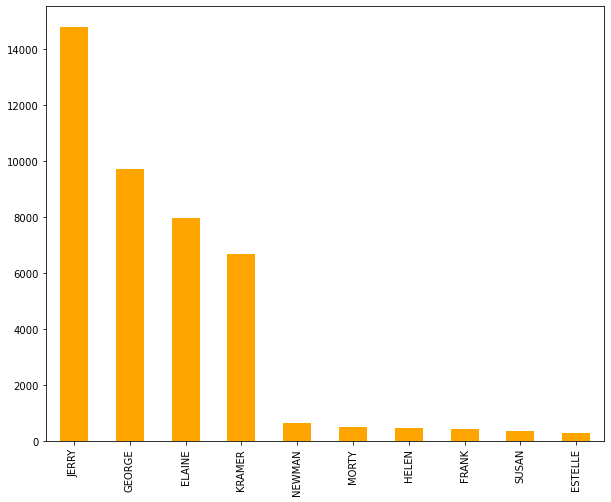

In [51]:
#Visualizing the top 10 characters with most number of dialogues
df_with_POS["Name"].value_counts().head(10).plot(kind="bar",color = 'Orange',figsize =(10,8))

In [52]:
# From the observation we can see that Jerry spoke most of the dialogue and from whicvalue_countscan interpret
# that he is the lead character in the play. selecting the top 6 charatcers from the play for model building.

In [53]:
#creating a new data frame for character who has spoken more than 500 dialogues in the script.
more_than_500_dialogues = [k for k in df_with_POS['Name'].value_counts().keys() if df_with_POS['Name'].value_counts()[k] > 500]

df_with_POS_more_than_500 = df_with_POS[(df_with_POS['Name'].isin(more_than_500_dialogues))]



In [54]:
#lets look at the new data frame
df_with_POS_more_than_500.head()

,Name,Dialogue,VB,PRP,WP,DT,VBZ,RB,VBP,WRB,...,FW,UH,RBR,LS,SYM,WP$,Word_count,char_count,avg_word_len,stopwords
0,JERRY,Do you know what this is all about? Do you kno...,22.0,23.0,2.0,16.0,7.0,8.0,18.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,189,998,4.285714,72
1,JERRY,"(pointing at George's shirt) See, to me, that ...",2.0,2.0,NaN,3.0,2.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,41,229,4.609756,14
2,GEORGE,Are you through?,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,16,4.666667,1
3,JERRY,"You do of course try on, when you buy?",NaN,2.0,NaN,NaN,NaN,NaN,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,9,38,3.333333,4
4,GEORGE,"Yes, it was purple, I liked it, I don't actual...",NaN,3.0,NaN,1.0,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14,80,4.785714,4


In [55]:
# looking at the characters with more than 500 dialogues-
df_with_POS_more_than_500['Name'].nunique()


6

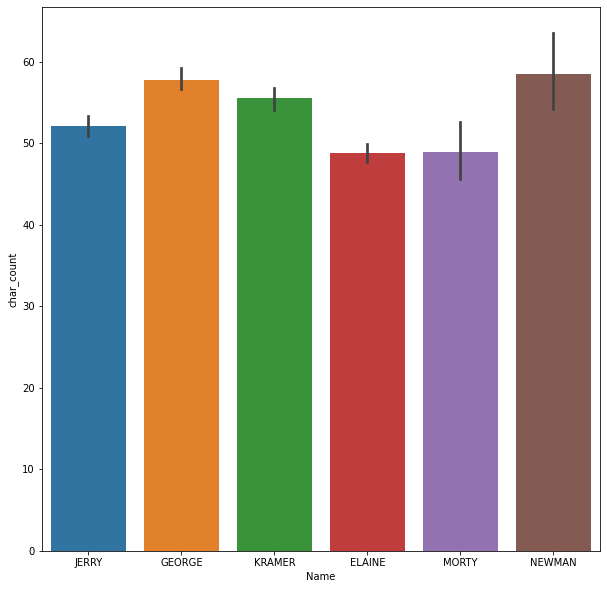

In [56]:
#From the top 6 characters visualizing the characters who spoke the longest dialogues.
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(ax=ax,y="char_count",x="Name",data=df_with_POS_more_than_500)

## Model Building

In [57]:
#Creating a response variable[label] that we will try to predict with our model.
#In this case it is the Name column.
df_with_POS_more_than_500['label'] = (df_with_POS_more_than_500['Name'])

In [58]:
df_with_POS_more_than_500['label']
#we have our response variable ready now

0         JERRY
1         JERRY
2        GEORGE
3         JERRY
4        GEORGE
          ...  
53984     JERRY
53986     JERRY
53988     JERRY
53990     JERRY
53992     JERRY
Name: label, Length: 40306, dtype: object

In [59]:
#We will convert our response variable to categorical for our model building purpose.
factor = pd.factorize(df_with_POS_more_than_500['label'])

In [60]:
factor

(array([0, 0, 1, ..., 0, 0, 0]),
 Index(['JERRY', 'GEORGE', 'KRAMER', 'ELAINE', 'MORTY', 'NEWMAN'], dtype='object'))

In [61]:
df_with_POS_more_than_500.label = factor[0]

In [62]:
#storing the names of our category in definition variable to convert in back afterwords
definitions = factor[1]

In [63]:
#looking at the definitions
definitions

Index(['JERRY', 'GEORGE', 'KRAMER', 'ELAINE', 'MORTY', 'NEWMAN'], dtype='object')

In [64]:
# We will first build a Random Forest model to have a rough estimate on the accuracy and other parameters,
#and after building one model we will further improve our model.
# Currently from our observations we know that the data is imbalanced.

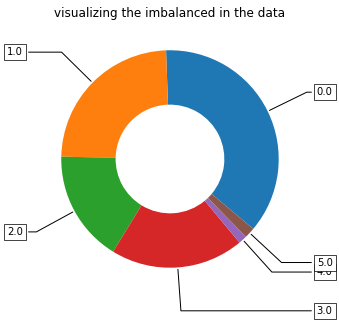

O: Jerry, 1: George, 2: Kramer, 3: Elaine, 4:Morty , 5: Newman


In [65]:
#visualizing the imbalanced in the data
fig, ax = plt.subplots(figsize=(15, 5), subplot_kw=dict(aspect="equal"))

label_name=[float(k) for k in Counter(df_with_POS_more_than_500['label'])]

label_count=[float(v) for v in Counter(df_with_POS_more_than_500['label']).values()]



wedges, texts = ax.pie(label_count, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(label_name[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("visualizing the imbalanced in the data")

plt.show()
print("O: Jerry, 1: George, 2: Kramer, 3: Elaine, 4:Morty , 5: Newman")

In [66]:
from collections import Counter
Counter(df_with_POS_more_than_500['label'])

Counter({0: 14786, 1: 9708, 2: 6684, 3: 7983, 4: 505, 5: 640})

In [67]:
# Our data frame has lot of Nan values which need to be replaced by a value for model building.
# We will replace all Nan values with 0
df_with_POS_more_than_500 = df_with_POS_more_than_500.fillna(0)
#df_with_POS_more_than_500.head()

In [68]:
#From here we can see that now we don't have any Na values in the df.
df_with_POS_more_than_500.isna().sum()

Name            0
Dialogue        0
VB              0
PRP             0
WP              0
DT              0
VBZ             0
RB              0
VBP             0
WRB             0
JJ              0
NN              0
TO              0
VBN             0
RP              0
CD              0
IN              0
RBS             0
NNS             0
NNP             0
VBG             0
MD              0
EX              0
PDT             0
VBD             0
PRP$            0
JJS             0
CC              0
POS             0
WDT             0
NNPS            0
JJR             0
FW              0
UH              0
RBR             0
LS              0
SYM             0
WP$             0
Word_count      0
char_count      0
avg_word_len    0
stopwords       0
label           0
dtype: int64

In [107]:
#Importing all libraries for Model building
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score,classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [70]:
X = df_with_POS_more_than_500.iloc[:,2:].drop(['label'],axis=1)
X.shape


(40306, 40)

In [71]:
y = df_with_POS_more_than_500['label']
y.shape

(40306,)

In [72]:
#splitting the data top train test, with 75% of the data into traing and remaining 25% data to testing,
# so that we can test out model on unseen data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21)

In [73]:
# Scaling out data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Random Forest

In [74]:
#Building a Random Forest classifier and fitiing the training and testing data to it.
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [75]:
#Making predictions using out trained model
y_pred = classifier.predict(X_test)
y_pred

array([0, 0, 2, ..., 2, 0, 0])

### Initial model Performance

In [76]:
#Reverse factorize (converting y_pred from 0s,1s, 2s to Jerry, George, kramer and so on)
reversefactor = dict(zip(range(6),definitions))
y_test = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)
#Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Characters'], colnames=['Predicted Characters']))

Predicted Characters  ELAINE  GEORGE  JERRY  KRAMER  MORTY  NEWMAN
Actual Characters                                                 
ELAINE                   163     359   1332     114      3       6
GEORGE                   199     475   1575     158      2       4
JERRY                    306     616   2547     231      6       8
KRAMER                   128     340   1034     143      3       5
MORTY                     21      35     73       6      0       0
NEWMAN                    16      52    110       6      1       0


In [77]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      ELAINE       0.20      0.08      0.12      1977
      GEORGE       0.25      0.20      0.22      2413
       JERRY       0.38      0.69      0.49      3714
      KRAMER       0.22      0.09      0.12      1653
       MORTY       0.00      0.00      0.00       135
      NEWMAN       0.00      0.00      0.00       185

    accuracy                           0.33     10077
   macro avg       0.17      0.18      0.16     10077
weighted avg       0.28      0.33      0.28     10077



Feature ranking:
1. feature 38 (0.137917)
2. feature 37 (0.132444)
3. feature 36 (0.069917)
4. feature 39 (0.065381)
5. feature 9 (0.053487)
6. feature 17 (0.042735)
7. feature 8 (0.040074)
8. feature 1 (0.039879)
9. feature 14 (0.038264)
10. feature 3 (0.036368)
11. feature 6 (0.036315)
12. feature 0 (0.036151)
13. feature 5 (0.033894)
14. feature 22 (0.029548)
15. feature 4 (0.023260)
16. feature 16 (0.021597)
17. feature 18 (0.021451)
18. feature 23 (0.018903)
19. feature 10 (0.018521)
20. feature 25 (0.016281)
21. feature 2 (0.012355)
22. feature 7 (0.011466)
23. feature 19 (0.011018)
24. feature 11 (0.010502)
25. feature 12 (0.010124)
26. feature 13 (0.009842)
27. feature 31 (0.005143)
28. feature 27 (0.004240)
29. feature 29 (0.002843)
30. feature 20 (0.002635)
31. feature 21 (0.002250)
32. feature 24 (0.001583)
33. feature 32 (0.001115)
34. feature 26 (0.000880)
35. feature 28 (0.000463)
36. feature 30 (0.000407)
37. feature 15 (0.000250)
38. feature 34 (0.000241)
39. feature 33

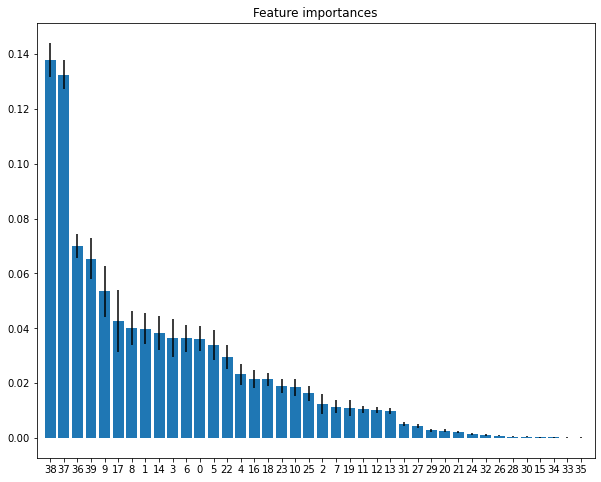

In [78]:
# Lets look at the important features of the model
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

new_indices = list()

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
    if importances[indices[f]] > 0.01:
        new_indices.append(indices[f])
        
# Plot the impurity-based feature importances of the forest
plt.figure(figsize= (10,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
         yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [79]:
# Lets try to build the model again with Selecting only important features( i.e feature with an imprtance of >0.01).
X_fewer_columns = X.iloc[:, new_indices]
X_fewer_columns
#here we are taking only 25 features based on their importance

,avg_word_len,char_count,Word_count,stopwords,NN,NNP,JJ,PRP,IN,DT,...,NNS,VBG,PRP$,TO,CC,WP,WRB,MD,VBN,RP
0,4.285714,998,189,72,30.0,2.0,17.0,23.0,8.0,16.0,...,4.0,4.0,2.0,3.0,0.0,2.0,4.0,2.0,3.0,7.0
1,4.609756,229,41,14,6.0,4.0,6.0,2.0,7.0,3.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,4.666667,16,3,1,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.333333,38,9,4,3.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4.785714,80,14,4,3.0,0.0,2.0,3.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53984,4.136364,112,22,5,4.0,8.0,0.0,2.0,2.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
53986,4.192308,134,26,9,5.0,3.0,3.0,1.0,2.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
53988,3.800000,47,10,4,3.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53990,3.888889,87,18,10,3.0,1.0,0.0,2.0,2.0,1.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [80]:
#Builidng the model again
X_train, X_test, y_train, y_test = train_test_split(X_fewer_columns, y, test_size = 0.25, random_state = 21)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [81]:
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [82]:
y_pred = classifier.predict(X_test)
#Reverse factorize (converting y_pred from 0s,1s, 2s to Jerry,Georger and kramer and so on )
reversefactor = dict(zip(range(6),definitions))
y_test = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Characters'], colnames=['Predicted Characters']))
print(classification_report(y_test,y_pred))

Predicted Characters  ELAINE  GEORGE  JERRY  KRAMER  MORTY  NEWMAN
Actual Characters                                                 
ELAINE                   157     354   1358      99      4       5
GEORGE                   199     445   1592     170      4       3
JERRY                    318     620   2555     210      3       8
KRAMER                   124     336   1050     134      3       6
MORTY                     14      34     84       3      0       0
NEWMAN                    15      43    116      10      1       0
              precision    recall  f1-score   support

      ELAINE       0.19      0.08      0.11      1977
      GEORGE       0.24      0.18      0.21      2413
       JERRY       0.38      0.69      0.49      3714
      KRAMER       0.21      0.08      0.12      1653
       MORTY       0.00      0.00      0.00       135
      NEWMAN       0.00      0.00      0.00       185

    accuracy                           0.33     10077
   macro avg       0.17      0

In [83]:
#So from the above classification report we can see that even after choosing the important features
#the accuracy of model didn't change much.

In [84]:
# As we know that the number of dialogues of Morty and Newman are very less, compared to Jerry and others
# and we don't know what all characters the client want us to consider.
#Assuming the client is only interested in the four main characters of the show, we will consider only
#Jerry, Elaine, Kramer and George for our further models.
#Though we can create synthetic data and balance the dataset, but in order to get better predicitions
#synthetic data won't give us beter results because of the high imbalance in the dataset. So if we want to predict
#on other characters, we can ask our
#client to provide more data on those characters.

#So as of now, moving forward with out assumption and considering four main characters(Jerry, George,
#Kramer, Elaine) for out further modelling.

### Reducing the number of Characters

In [85]:
# Reducing the number of characters
df_with_POS_more_than_500_fewer_classes = df_with_POS_more_than_500[df_with_POS_more_than_500['label'].isin([0,1,2,3])]
Counter(df_with_POS_more_than_500_fewer_classes['label'])

Counter({0: 14786, 1: 9708, 2: 6684, 3: 7983})

<Figure size 288x576 with 0 Axes>

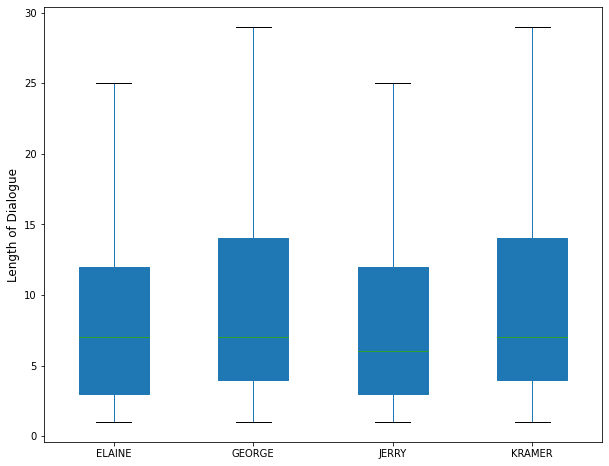

In [86]:
### let us try to see the Word_count according to the category (Names)
fig = plt.figure(figsize=(4,8))
#fig,ax = plt.subplots()
#cmap = cm.ScalarMappable(cmap='rainbow')
df_with_POS_more_than_500_fewer_classes.assign(index=df_with_POS_more_than_500_fewer_classes.groupby('Name').cumcount()).pivot('index','Name','Word_count').plot(kind='box',
                                                                                                  patch_artist=True,
                                                                                                  showfliers=False, widths=(0.5, 0.5 ,0.5, 0.5),
                                                                                                  figsize=(10,8),fontsize=10)
plt.ylabel('Length of Dialogue',fontsize = 12)


plt.show()

In [87]:
#Looking at the data frame with fewer classes
df_with_POS_more_than_500_fewer_classes.head()

,Name,Dialogue,VB,PRP,WP,DT,VBZ,RB,VBP,WRB,...,UH,RBR,LS,SYM,WP$,Word_count,char_count,avg_word_len,stopwords,label
0,JERRY,Do you know what this is all about? Do you kno...,22.0,23.0,2.0,16.0,7.0,8.0,18.0,4.0,...,0.0,0.0,0.0,0.0,0.0,189,998,4.285714,72,0
1,JERRY,"(pointing at George's shirt) See, to me, that ...",2.0,2.0,0.0,3.0,2.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,41,229,4.609756,14,0
2,GEORGE,Are you through?,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3,16,4.666667,1,1
3,JERRY,"You do of course try on, when you buy?",0.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,9,38,3.333333,4,0
4,GEORGE,"Yes, it was purple, I liked it, I don't actual...",0.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,14,80,4.785714,4,1


### Modeling on the new data with fewer characters

In [88]:
#Creatinfg our training and predictor variables
X = df_with_POS_more_than_500_fewer_classes.iloc[:,2:].drop(['label'],axis=1)
X.shape

y = df_with_POS_more_than_500_fewer_classes['label']

In [89]:
#Modle Building with fewer classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

### Predicting Results

In [91]:
#Making Predictions on the newdataset
y_pred = classifier.predict(X_test)
#Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
reversefactor = dict(zip(range(4),definitions))
y_test = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Characters'], colnames=['Predicted Characters']))
print(classification_report(y_test,y_pred))
print("JERRY: 0, GEORGE: 1, KRAMER: 2, ELAINE: 3")

Predicted Characters  ELAINE  GEORGE  JERRY  KRAMER
Actual Characters                                  
ELAINE                   153     337   1360     139
GEORGE                   192     441   1645     144
JERRY                    299     630   2568     185
KRAMER                   140     326   1089     143
              precision    recall  f1-score   support

      ELAINE       0.20      0.08      0.11      1989
      GEORGE       0.25      0.18      0.21      2422
       JERRY       0.39      0.70      0.50      3682
      KRAMER       0.23      0.08      0.12      1698

    accuracy                           0.34      9791
   macro avg       0.27      0.26      0.24      9791
weighted avg       0.29      0.34      0.28      9791

JERRY: 0, GEORGE: 1, KRAMER: 2, ELAINE: 3


In [92]:
# So from the above classification report we can observe that the accuracy of model has increased, but the increase is very little.
# If we look at the Precision values in the classification report, it has increased compared to the last model report.

In [93]:
#Let's change the model and see if it increases the accuracy

### Support Vector Classifier

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [96]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X_train, y_train)

SVC(decision_function_shape='ovo')

In [97]:
y_pred = clf.predict(X_test)

print(pd.crosstab(y_test, y_pred, rownames=['Actual Characters'], colnames=['Predicted Characters']))
print(classification_report(y_test,y_pred))
print("JERRY: 0, GEORGE: 1, KRAMER: 2, ELAINE: 3")

Predicted Characters     0    1   2  3
Actual Characters                     
0                     3551  115   7  9
1                     2318   85  15  4
2                     1629   51  10  8
3                     1922   55   9  3
              precision    recall  f1-score   support

           0       0.38      0.96      0.54      3682
           1       0.28      0.04      0.06      2422
           2       0.24      0.01      0.01      1698
           3       0.12      0.00      0.00      1989

    accuracy                           0.37      9791
   macro avg       0.26      0.25      0.15      9791
weighted avg       0.28      0.37      0.22      9791

JERRY: 0, GEORGE: 1, KRAMER: 2, ELAINE: 3


In [98]:
# So from the above classification report we can see that, the prediction accuracy of our model is
#further increased by changing our model.
# Also there is a good change in the Precision values compared to the last report.

# Moving forward, lets create some more feature. Which might increase our model performance further.

### Sentiment Analysis

In [99]:
df_with_POS_more_than_500_fewer_classes['Dialogue'][:].apply(lambda x: TextBlob(x).sentiment)

0                      (0.215, 0.37857142857142856)
1                     (-0.13272727272727275, 0.608)
2                                        (0.0, 0.0)
3                                        (0.0, 0.0)
4                                       (0.3, 0.45)
                            ...                    
53984                                    (0.5, 0.6)
53986      (0.3666666666666667, 0.8333333333333334)
53988                                    (0.5, 1.0)
53990    (-0.15555555555555559, 0.2888888888888889)
53992                                   (1.0, 0.75)
Name: Dialogue, Length: 39161, dtype: object

In [100]:
df_with_POS_more_than_500_fewer_classes['sentiment'] = df_with_POS_more_than_500_fewer_classes['Dialogue'].apply(lambda x: TextBlob(x).sentiment[0] )

In [101]:
#looking for the new column sentiment in the data frame
df_with_POS_more_than_500_fewer_classes.head()

,Name,Dialogue,VB,PRP,WP,DT,VBZ,RB,VBP,WRB,...,RBR,LS,SYM,WP$,Word_count,char_count,avg_word_len,stopwords,label,sentiment
0,JERRY,Do you know what this is all about? Do you kno...,22.0,23.0,2.0,16.0,7.0,8.0,18.0,4.0,...,0.0,0.0,0.0,0.0,189,998,4.285714,72,0,0.215000
1,JERRY,"(pointing at George's shirt) See, to me, that ...",2.0,2.0,0.0,3.0,2.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,41,229,4.609756,14,0,-0.132727
2,GEORGE,Are you through?,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,3,16,4.666667,1,1,0.000000
3,JERRY,"You do of course try on, when you buy?",0.0,2.0,0.0,0.0,0.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,9,38,3.333333,4,0,0.000000
4,GEORGE,"Yes, it was purple, I liked it, I don't actual...",0.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,14,80,4.785714,4,1,0.300000


### Balancing the Data (Generating synthetic data)

In [102]:
# As we have observed above the data is highly imbalanced, lets balance the data and create the models.

In [103]:
#Lets see the number of samples of each category we have
Counter(df_with_POS_more_than_500_fewer_classes['Name'])

Counter({'JERRY': 14786, 'GEORGE': 9708, 'KRAMER': 6684, 'ELAINE': 7983})

In [105]:
#The above count shows that we have the largest datasamples for jerry, where as less than half of what jerry has for Kramer.
# so lets balance the data.

In [111]:
#Creating our training and predictor variables
X = df_with_POS_more_than_500_fewer_classes.iloc[:,2:].drop(['label'],axis=1)
X.shape

y = df_with_POS_more_than_500_fewer_classes['label']

In [112]:
# this will generate synthetic data and the data will be balanced
oversample = SMOTE()
X_sm, y_sm = oversample.fit_resample(X, y)
Counter(y_sm)

Counter({0: 14786, 1: 14786, 2: 14786, 3: 14786})

In [114]:
#Dividing the data into train test to create new model on balanced data
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size = 0.25, random_state = 21)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Random forest model on balanced data

In [115]:
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
classifier.fit(X_sm, y_sm)

y_pred = classifier.predict(X_test)

print(pd.crosstab(y_test, y_pred, rownames=['Actual Characters'], colnames=['Predicted Characters']))
print(classification_report(y_test,y_pred))
print("JERRY: 0, GEORGE: 1, KRAMER: 2, ELAINE: 3")

Predicted Characters    0    1     2     3
Actual Characters                         
0                     436  425   861  1920
1                     387  543   933  1884
2                     294  446  1068  1881
3                     410  424   861  2013
              precision    recall  f1-score   support

           0       0.29      0.12      0.17      3642
           1       0.30      0.14      0.19      3747
           2       0.29      0.29      0.29      3689
           3       0.26      0.54      0.35      3708

    accuracy                           0.27     14786
   macro avg       0.28      0.27      0.25     14786
weighted avg       0.28      0.27      0.25     14786

JERRY: 0, GEORGE: 1, KRAMER: 2, ELAINE: 3


In [116]:
# we can observe from the above classification report that, there is improvement in the precision value for all 4 classes, also
# the f1 score for the minority classes has incresed significantly.

In [117]:
# We can also perform undersampling which will give us better result but it wont be a good idea to do so because,
#lowering the sample size will increase the accuracy but the model performance on the new unseen data will decrease, which in short might
#overfit our model.

# Light GBM Model on balanced data

In [118]:
from lightgbm import LGBMClassifier
params = {}
params['learning_rate'] = 0.05
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['metric'] = 'multi_logloss'
params['n_thread'] = 3
params['num_leaves'] = 64
params['max_bin'] = 512
params['subsample_for_bin'] = 200
params['bagging_fraction'] = 0.75
params['bagging_freq'] = 1
params['colsample_bytree'] = 0.8
params['reg_alpha'] = 5
params['reg_lambda'] = 10
params['min_split_gain'] = 0.5
params['min_child_weight'] = 1
params['min_child_samples'] = 5
params['scale_pause_weight'] = 1
params['num_class'] =5
params['max_depth'] = 100
params['n_estimators'] = 10000
params['min_data_in_leaf']=1875

print("Starting LightGBM. Train shape: {}, test shape: {}".format(X_train.shape, X_test.shape))



Starting LightGBM. Train shape: (44358, 41), test shape: (14786, 41)


In [119]:
lgb = LGBMClassifier(**params)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)

[LightGBM] [Warning] Unknown parameter: scale_pause_weight
[LightGBM] [Warning] Unknown parameter: n_thread
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1875, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=1875
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


In [120]:
print(pd.crosstab(y_test, y_pred, rownames=['Actual Characters'], colnames=['Predicted Characters']))
print(classification_report(y_test,y_pred))
print("JERRY: 0, GEORGE: 1, KRAMER: 2, ELAINE: 3")

Predicted Characters    0    1     2     3
Actual Characters                         
0                     436  425   861  1920
1                     387  543   933  1884
2                     294  446  1068  1881
3                     410  424   861  2013
              precision    recall  f1-score   support

           0       0.29      0.12      0.17      3642
           1       0.30      0.14      0.19      3747
           2       0.29      0.29      0.29      3689
           3       0.26      0.54      0.35      3708

    accuracy                           0.27     14786
   macro avg       0.28      0.27      0.25     14786
weighted avg       0.28      0.27      0.25     14786

JERRY: 0, GEORGE: 1, KRAMER: 2, ELAINE: 3


### PCA- Principle Component Analysis

In [121]:
# Let's Perform PCA to reduce the dimensionality of our data set consisting of many variables 
# correlated with each other, either heavily or lightly.

In [122]:
#Final Features before splitting and training data again. 
features_train = df_with_POS_more_than_500_fewer_classes.iloc[:,2:].drop(['label'],axis=1)
features_test = df_with_POS_more_than_500_fewer_classes['label']

In [123]:
print('These are your features:',features_train.columns)

These are your features: Index(['VB', 'PRP', 'WP', 'DT', 'VBZ', 'RB', 'VBP', 'WRB', 'JJ', 'NN', 'TO',
       'VBN', 'RP', 'CD', 'IN', 'RBS', 'NNS', 'NNP', 'VBG', 'MD', 'EX', 'PDT',
       'VBD', 'PRP$', 'JJS', 'CC', 'POS', 'WDT', 'NNPS', 'JJR', 'FW', 'UH',
       'RBR', 'LS', 'SYM', 'WP$', 'Word_count', 'char_count', 'avg_word_len',
       'stopwords', 'sentiment'],
      dtype='object')


In [124]:
# Before performing PCA lets scale(or Normalize) our data first.It is important because PCA is a variance maximizing exercise.
# It projects your original data onto directions which maximize the variance.
scaler = StandardScaler()
scaler.fit(features_train)
scaled_f = scaler.transform(features_train)

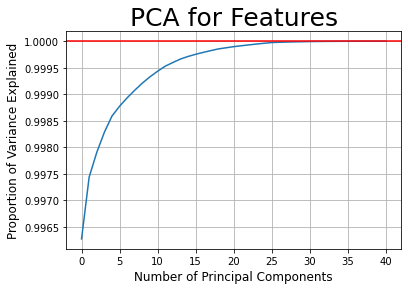

In [189]:
#Let's visualize the amount of total variance explained by the different principal components.
pca = PCA().fit(features_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.ylabel('Proportion of Variance Explained',fontsize = 12)
plt.xlabel('Number of Principal Components',fontsize = 12)
plt.axhline(y=1, color='r', linestyle='-')
plt.title('PCA for Features',fontsize = 25)
plt.show()

In [126]:
scaled_f.shape

(39161, 41)

In [127]:
#Now lets'reduce the dimensions of our features, Without losing any characterstics.
new_features = pd.DataFrame(PCA(n_components=15).fit(scaled_f).transform(scaled_f))
new_features.shape

(39161, 15)

In [128]:
# From the above shape we can see that the dimentions of our features are reduced from 41 to 15.

### Neural Network - MLP Classifier

In [129]:
X_train, X_test, y_train, y_test = train_test_split(new_features,
                                                    features_test,test_size = 0.20, random_state = 21)

In [130]:
from sklearn.neural_network import MLPClassifier

In [131]:
clf = MLPClassifier(random_state=1, max_iter=1000).fit(X_train, y_train)

In [132]:
y_pred = clf.predict(X_test)
print(pd.crosstab(y_test, y_pred, rownames=['Actual Characters'], colnames=['Predicted Characters']))
print(classification_report(y_test,y_pred))
print("JERRY: 0, GEORGE: 1, KRAMER: 2, ELAINE: 3")

Predicted Characters     0    1   2   3
Actual Characters                      
0                     2747  113  32  47
1                     1799   97  25  25
2                     1233   67  29  36
3                     1463   60  30  30
              precision    recall  f1-score   support

           0       0.38      0.93      0.54      2939
           1       0.29      0.05      0.08      1946
           2       0.25      0.02      0.04      1365
           3       0.22      0.02      0.03      1583

    accuracy                           0.37      7833
   macro avg       0.28      0.26      0.17      7833
weighted avg       0.30      0.37      0.24      7833

JERRY: 0, GEORGE: 1, KRAMER: 2, ELAINE: 3


In [133]:
#Let's change our model and see if it affectes the accuracy

## Using Keras 

In [173]:
#Importing the libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing.text import Tokenizer

In [174]:
#Defining the Parameters
words = 15 
num_classes = 4

In [175]:
#creating the model

model = Sequential()
model.add(Dense(512, input_shape=(words,)))
model.add(Activation('softmax'))
model.add(Dropout(0.5))
model.add(Dense(512, input_shape=(words,)))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(512, input_shape=(words,)))
model.add(Activation('softmax'))
model.add(Dropout(0.5))
model.add(Dense(128, input_shape=(words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [176]:
#Comiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [177]:
#Fitting the model on our data
model.fit(X_train, y_train, epochs=100, batch_size=500)

Epoch 1/100
63/63 [==============================] - 1s 12ms/step - loss: 1.6062 - accuracy: 0.2785
Epoch 2/100
63/63 [==============================] - 1s 11ms/step - loss: 1.6062 - accuracy: 0.2928
Epoch 3/100
63/63 [==============================] - 1s 12ms/step - loss: 1.6062 - accuracy: 0.2541
Epoch 4/100
63/63 [==============================] - 1s 13ms/step - loss: 1.6062 - accuracy: 0.2412
Epoch 5/100
63/63 [==============================] - 1s 12ms/step - loss: 1.6062 - accuracy: 0.2406
Epoch 6/100
63/63 [==============================] - 1s 13ms/step - loss: 1.6062 - accuracy: 0.2343
Epoch 7/100
63/63 [==============================] - 1s 13ms/step - loss: 1.6062 - accuracy: 0.2536
Epoch 8/100
63/63 [==============================] - 1s 14ms/step - loss: 1.6062 - accuracy: 0.2485
Epoch 9/100
63/63 [==============================] - 1s 14ms/step - loss: 1.6062 - accuracy: 0.2265
Epoch 10/100
63/63 [==============================] - 1s 13ms/step - loss: 1.6062 - accuracy: 0.2458

In [178]:
# So the training set accuracy is 25% which is not better than above models.
# Let's try Light GBM Model


### Light GBM Model

In [134]:
from lightgbm import LGBMClassifier
params = {}
params['learning_rate'] = 0.05
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['metric'] = 'multi_logloss'
params['n_thread'] = 3
params['num_leaves'] = 64
params['max_bin'] = 512
params['subsample_for_bin'] = 200
params['bagging_fraction'] = 0.75
params['bagging_freq'] = 1
params['colsample_bytree'] = 0.8
params['reg_alpha'] = 5
params['reg_lambda'] = 10
params['min_split_gain'] = 0.5
params['min_child_weight'] = 1
params['min_child_samples'] = 5
params['scale_pause_weight'] = 1
params['num_class'] =5
params['max_depth'] = 100
params['n_estimators'] = 10000
params['min_data_in_leaf']=1875

print("Starting LightGBM. Train shape: {}, test shape: {}".format(X_train.shape, X_test.shape))



Starting LightGBM. Train shape: (31328, 15), test shape: (7833, 15)


In [135]:
lgb = LGBMClassifier(**params)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)

[LightGBM] [Warning] Unknown parameter: scale_pause_weight
[LightGBM] [Warning] Unknown parameter: n_thread
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1875, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=1875
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


In [136]:
print(pd.crosstab(y_test, y_pred, rownames=['Actual Characters'], colnames=['Predicted Characters']))
print(classification_report(y_test,y_pred))
print("JERRY: 0, GEORGE: 1, KRAMER: 2, ELAINE: 3")

Predicted Characters     0    1   2   3
Actual Characters                      
0                     2747  113  32  47
1                     1799   97  25  25
2                     1233   67  29  36
3                     1463   60  30  30
              precision    recall  f1-score   support

           0       0.38      0.93      0.54      2939
           1       0.29      0.05      0.08      1946
           2       0.25      0.02      0.04      1365
           3       0.22      0.02      0.03      1583

    accuracy                           0.37      7833
   macro avg       0.28      0.26      0.17      7833
weighted avg       0.30      0.37      0.24      7833

JERRY: 0, GEORGE: 1, KRAMER: 2, ELAINE: 3


In [143]:
# So looking at the accuracy matrix  we will select Light LGB model as our final model and train this model over full data set.
# The F1 score and the precision value for all 4 classes is better then all other models that we ran hence we chose this model.

In [139]:
#Fitting the model on all data
lgb.fit(new_features,features_test)

[LightGBM] [Warning] Unknown parameter: scale_pause_weight
[LightGBM] [Warning] Unknown parameter: n_thread
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1875, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=1875
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75


LGBMClassifier(bagging_fraction=0.75, bagging_freq=1, colsample_bytree=0.8,
               learning_rate=0.05, max_bin=512, max_depth=100,
               metric='multi_logloss', min_child_samples=5, min_child_weight=1,
               min_data_in_leaf=1875, min_split_gain=0.5, n_estimators=10000,
               n_thread=3, num_class=5, num_leaves=64, objective='multiclass',
               reg_alpha=5, reg_lambda=10, scale_pause_weight=1,
               subsample_for_bin=200)

In [180]:
#Provide the test file that we want to predict.
#lgb.predict('path to the dialogues that needs to be predicted')

In [142]:
# As we can see that the model accuracy of our final model is low and that is beacuse the data set is highly imbalanced.
# Apart from the accuracy from all our models above we can see that the precision and f1 score of our models have improved 
# consistantly with small increment as we changed our model and did some data manipulations and feature addition.

# To further increase our accuracy we can ask our client for more data samples, which will surely help in model training and 
# increasing the model accuracy.

# The data is highly imbalanced which is the root cause of the low accuracy, so we can ask out client to provide more data on the 
# minority classes.

# If not we can ask our client which charaters they are interested in, as from all our analysis above we could see that,most of the data
# samples are for Jerry and George, where Jerry being the dominant. If the client is not interested in predict any one of these
# we can remove for example jerry from our data sample, which will also increase the accuray of our model significantly.

# For the model deployment- the model definitely need improvement which can be made by providing more training data,
# for deployment the model need to be trained every week as it will improve further.
# The deployment team should also create a feedback mechanism which will train the model for every test case that has been
# passed on the app.



In [141]:
# It will be a continuos learning model which will be running on the cloud, and through internet the model will be connected 
# to the app, whenever a user enter a dialogue the app will connect the model on the cloud and the model will classify that
# dialogue and provide the results.
# Also the model will get trained on the provided instance and the feedback mechanism will tell the model how it performed and
# it will learn from the feedback as well.
# This way the model will be improved at each instance passed over it and will provide more accurate results.